In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from __future__ import division

In [2]:
x=pd.read_excel("var4.xls") #татнефть

In [3]:
x.head()

,Date,BID,ASK,Open price,Min,Max,Close price,AVG,Oborot,Amount of deals
0,30.04.2018,473.1,473.4,466.0,462.4,475.5,475.5,470.0,46626218,795
1,28.04.2018,464.0,464.4,464.3,462.8,469.7,464.4,465.6,10230775,438
2,27.04.2018,463.5,463.9,476.7,461.8,479.7,466.9,470.9,176551154,1917
3,26.04.2018,476.0,476.4,461.3,458.6,476.7,476.7,471.4,125440832,2547
4,25.04.2018,457.7,458.3,451.8,447.0,461.0,460.0,455.9,75728652,1577


In [4]:
x.columns.get_values

<bound method Index.get_values of Index([u'Date', u'BID', u'ASK', u'Open price', u'Min', u'Max', u'Close price',
       u'AVG', u'Oborot', u'Amount of deals'],
      dtype='object')>

In [5]:
# визуализация исходных данных

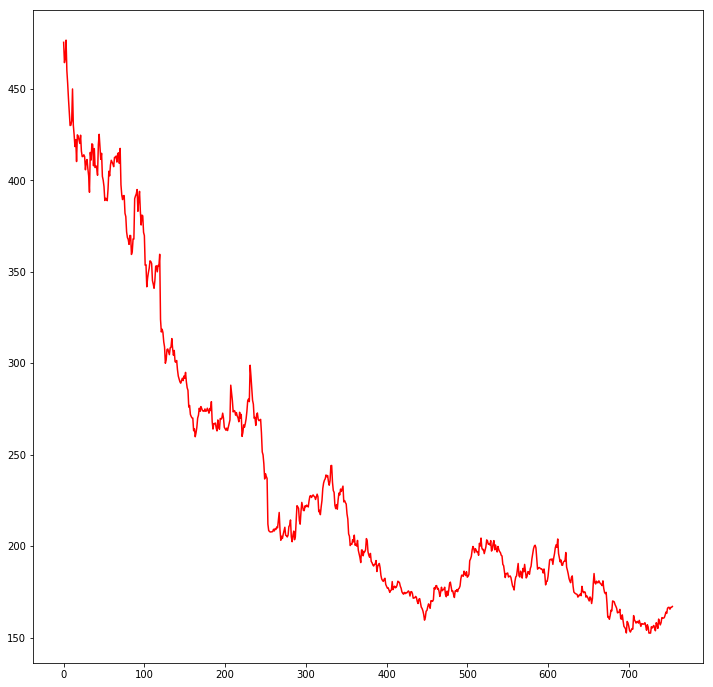

In [6]:
plt.figure(figsize=(12,12))
plt.plot(range(0, 755), x["Close price"], 'red')
plt.show()

In [7]:
### rolling_mean_data - rolling mean of close price array
### rolling_mean_window - parametr of rolling mean
### min_size - minimum size of time series for train dataset 
### eps - bound of 'plato'  
class finance:
    def __init__(self, k_neighbors = 5, rolling_mean_window = 4, min_size = 3, eps = 0.01, metrics = 'euclidean'):
        self.rolling_mean_window = rolling_mean_window
        self.min_size = min_size
        self.eps = eps
        self.metrics = metrics
        self.k = k_neighbors
        if self.metrics == 'euclidean':
            self.distance = self.euclidean_distance
    
    def rolling_mean(self, data):
        self.rolling_mean_data = np.nan_to_num(data.rolling(self.rolling_mean_window).mean())
    
    def get_kinks(self):
        kinks=[0]
        for i in range(1, len(self.rolling_mean_data) - 1):
           # print self.rolling_mean_data[i-1], self.rolling_mean_data[i], self.rolling_mean_data[i+1]
            if(self.rolling_mean_data[i]-self.rolling_mean_data[i-1])*(self.rolling_mean_data[i] - self.rolling_mean_data[i+1])>0:
                kinks.append(i)
        self.kinks = kinks
        
    def make_marks(self, x):
        if len(x) > 1:
            if abs(np.max(x) - np.min(x)) < self.eps:
                return 0
            else:
               # print x[0]
                return np.sign(x[0] - x[-1])
        else:
            print 'Error: some length of interval <= 1'
    
    def extract_features(self, data, index):
        features = []
        for i in range(index, index + len(data)):
            features.append([data['Close price'][i] - data['Open price'][i], data['Max'][i] - data['Min'][i], \
                            data['Max'][i] / data['Min'][i], data['Close price'][i] / data['Open price'][i], \
                            np.sign(data['Close price'][i] - data['Open price'][i])])
       # print '-'*80    
        return features      
    
    def make_dataset(self, data):
        dataset = []
        marks = []
        for i in range(1, len(self.kinks)):
            if self.kinks[i] - self.kinks[i-1] >= self.min_size:
                dataset.append(self.extract_features(data[self.kinks[i-1] : self.kinks[i]], self.kinks[i-1]))
                marks.append(self.make_marks(self.rolling_mean_data[self.kinks[i-1] : self.kinks[i]]))
        marks.append(self.make_marks(self.rolling_mean_data[self.kinks[-1]:]))    
        # delete a little series               
        # make target
        target = marks[1:]
        return dataset, target
        
    def euclidean_distance(self, x, y):
        x = np.array(x)
        y = np.array(y)
        return np.sqrt(np.sum((x-y)**2))
    
    # when we want to predict future, we should not look there
    def right_split(self, X, y, test_size = 0.25):
        size = int(len(y) * (1 - test_size))
        X_train , y_train = X[:size], y[:size] 
        X_test , y_test = X[size:], y[size:]
        return X_train, X_test, y_train, y_test 
    
    def prepare_data(self, data):
        self.rolling_mean(data['Close price'])
        self.get_kinks()
        dataset, target = self.make_dataset(data)
        return dataset, target
    
    def predict(self, X_train, y_train, x):
        distance_list = []
        for x_train in X_train:
            min_size = min(len(x), len(x_train))
            distance_list.append(self.distance(x[len(x) - min_size : ], x_train[len(x_train) - min_size : ]))
        index = np.argsort(distance_list)[:self.k]
        marks = np.array(y_train)[index]
        marks , count = np.unique(marks, return_counts = True)
        return marks[np.argmax(count)]
        
    def fit_predict(self, X_train, y_train, X_test):
        pred = []
        for x in X_test:
            pred.append(self.predict(X_train, y_train, x))
        return pred
    
    def cross_predict(self, X_train, y_train, x):
        distance_list = []
        for x_train in X_train:
            min_size = min(len(x), len(x_train))
            distance_list.append(self.distance(x[len(x) - min_size : ], x_train[len(x_train) - min_size : ]))
        index = np.argsort(distance_list)[:self.k + 1]
        marks = np.array(y_train)[index]
        marks , count = np.unique(marks, return_counts = True)
        return marks[np.argmax(count)][1:]
    
    def KNN_cross_validation(self, X, y):
        pred = []
        for x in X:
            pred.append(self.predict(X, y, x))
        return pred
    
    def check(self, y_predict, y_right):
        count_sum = 0
        for i in range(len(y_predict)):
            if y_predict[i] == y_right[i]:
                count_sum += 1
        return count_sum / len(y_predict)       
            
        

In [356]:
### поменять названия столбцов в таблице
### добавить комментарии
### пока что единичные случаи просто удаляются, потом надо будет попробовать их добавить
### смотреть расстояние скользящим окном
### листы преобразовать в numpy array

In [522]:
first_rocket = finance(rolling_mean_window=3)

In [523]:
data, target = first_rocket.prepare_data(x)

In [524]:
X_train, X_test, y_train, y_test = first_rocket.right_split(data, target)

In [529]:
pred = first_rocket.fit_predict(X_train, y_train, X_test)

In [530]:
first_rocket.check(pred, y_test)

0.53125

In [8]:
statistic = np.zeros((72, 5))

In [9]:
# selection the best parametrs 
rolling_mean_window = [2, 3, 4]
k_mean = [3, 4, 5, 6, 7, 8]
min_size = [2, 3, 4, 5]
i = 0
for rol in rolling_mean_window:
    for k in k_mean:
        for m in min_size:
            first_rocket = finance(rolling_mean_window=rol, min_size = m, k_neighbors = k)
            data, target = first_rocket.prepare_data(x)
           # X_train, X_test, y_train, y_test = first_rocket.right_split(data, target)
           # pred = first_rocket.fit_predict(X_train, y_train, X_test)
            pred = first_rocket.KNN_cross_validation(data, target)
            statistic[i] =  np.array([int(rol), int(k), int(m), first_rocket.check(pred, target), int(len(target))])
            i += 1
            

In [10]:
temp_index = np.argsort(statistic[:, 3])
new_stat = statistic[temp_index]
new_stat[-1:]

array([[  4.        ,   3.        ,   2.        ,   0.81355932,
        118.        ]])

In [10]:
table = pd.DataFrame(statistic, columns=['rolling mean window', 'k neighbors', 'min size', 'result', 'size of data', 'size of test data'])

In [11]:
table.to_excel('stat_tatneft.xlsx')